In [1]:
import numpy as np
import math
from scipy.spatial.distance import cityblock
import matplotlib.pyplot as plt
from re import split

In [4]:
# statistics of finishing time (unit: s)
fast_mean, fast_sigma=477.1, 42.4
slow_mean, slow_sigma=941, 414.4
medi_mean, medi_sigma=692.1, 92.5
N_pickers_fast, N_pickers_medium, N_pickers_slow = 4, 4, 4
# statistics of moving velocity while picking(unit: m/s)
v_fast, v_slow, v_medi = 0.0566, 0.0337, 0.0424
w_fast, w_slow, w_medi = 1.4662, 0.7663, 1.1238
model_truth = {"model_fast":[fast_mean,fast_sigma,v_fast,w_fast],
               "model_medi":[medi_mean,medi_sigma,v_medi,w_medi],
               "model_slow":[slow_mean,slow_sigma,v_slow,w_slow]}
model_truth

{'model_fast': [477.1, 42.4, 0.0566, 1.4662],
 'model_medi': [692.1, 92.5, 0.0424, 1.1238],
 'model_slow': [941, 414.4, 0.0337, 0.7663]}

In [184]:
# sampling of finishing intervals of pickers' finishing time
f_t_sample_fast = np.random.normal(fast_mean,fast_sigma,N_pickers_fast)
f_t_sample_slow = np.random.normal(slow_mean,slow_sigma,N_pickers_slow)
f_t_sample_medium = np.random.normal(medium_mean,medium_sigma,N_pickers_medium)
f_t_sample=np.concatenate((f_t_sample_fast,f_t_sample_slow,f_t_sample_medium)) # (12,)
# 0 means fast, 1 means medium, 2 means slow
f_t_model = (np.zeros(N_pickers_fast),np.ones(N_pickers_slow)*2,np.ones(N_pickers_medium))
f_t_model = np.concatenate(f_t_model).astype(int)
# walking velocity and moving velocity of pickers
v_t_pickers=(np.ones(N_pickers_fast)*v_fast,np.ones(N_pickers_slow)*v_slow,np.ones(N_pickers_medium)*v_medium)
v_pickers = np.concatenate(v_t_pickers)
w_t_pickers=(np.ones(N_pickers_fast)*w_fast,np.ones(N_pickers_slow)*w_slow,np.ones(N_pickers_medium)*w_medium)
w_pickers = np.concatenate(w_t_pickers)
# shuffle to initialize the prediction
fur_pos = np.random.permutation(N_pickers_fast+N_pickers_medium+N_pickers_slow)
#index is pickers' position from left to right
f_t_sample = f_t_sample[fur_pos]
v_pickers = v_pickers[fur_pos]
w_pickers = w_pickers[fur_pos]
f_t_model = f_t_model[fur_pos] # fast, medium or slow
# fields information (unit: m)
origin = np.asarray([0,0])
furrow_width = 28*0.0254
berry_width = 14*0.0254
furrow_length = 5400*0.0254
picker_num = N_pickers_fast+N_pickers_medium+N_pickers_slow
robot_num = 4
robot_v = 1 # m/s
y_head = 40*0.0254 # y coordinate of furrow head
# initialize robots and pickers positions
def field_initialization(picker_num, robot_num, y_head, furrow_width, berry_width, furrow_length):
    center_1 = [(furrow_width+berry_width)*picker_num/2, 0]
    center_2 = [(furrow_width+berry_width)*picker_num*3/2, 0] # (x_center2, y_center2)
    center = np.array([center_1, center_2])
    r_initial_pos = []
    p_initial_pos = []
    for i in range(robot_num):
        r_initial_pos.append(center_1) # robots are initially at center 1
    r_initial_pos = np.asarray(r_initial_pos) # m*2, m1:r_x, m2:r_y

    for i in range(picker_num):
        x = furrow_width/2 + (furrow_width+berry_width)*i
        pos = [x, y_head + furrow_length]
        p_initial_pos.append(pos) 	 # pickers are initially at further end of furrows
    p_initial_pos = np.asarray(p_initial_pos) # n*2, n1:p_x, n2:p_y
    return p_initial_pos, r_initial_pos, center
p_initial_pos, r_initial_pos, center = field_initialization(picker_num, robot_num, y_head, furrow_width, berry_width, furrow_length)
print center

[[  6.4008   0.    ]
 [ 19.2024   0.    ]]


In [198]:
# target_pos={}
# i=1
# target_pos={"ft"+str(i):1}
# # print p_initial_pos
# # for pos in p_initial_pos:
# #     print pos[0]
# # math.floor(1.4224-0.3556/1.0668)+1
# a=np.array([1,2]).reshape(-1,1)
# b=np.array([2,3]).reshape(-1,1)
# c=[]
# c.append(a)
# c.append(b)
# c=np.concatenate(c,axis=1)
for i, k in enumerate(np.ones(1)):
    print i,k

0 1.0


[array([[   0.3556    ],
       [ 108.55856073]]), array([[  0.3556    ],
       [ 85.63245157]]), array([[  0.3556    ],
       [ 62.70634242]])]
[array([[   1.4224    ],
       [ 108.41926428]]), array([[  1.4224    ],
       [ 84.08182283]])]
[array([[   2.4892    ],
       [ 112.02449724]]), array([[  2.4892    ],
       [ 83.34820691]]), array([[  2.4892    ],
       [ 54.67191659]])]
[array([[   3.556     ],
       [ 111.61491354]]), array([[  3.556     ],
       [ 87.39855388]]), array([[  3.556     ],
       [ 63.18219421]])]
[array([[   4.6228    ],
       [ 109.87845309]]), array([[  4.6228    ],
       [ 80.54728321]])]
[array([[  5.6896    ],
       [ 98.93003261]])]
[array([[   6.7564    ],
       [ 107.72714789]]), array([[  6.7564    ],
       [ 79.29959334]])]
[array([[  7.8232   ],
       [ 90.8224446]])]
[array([[   8.89      ],
       [ 105.98939139]]), array([[  8.89     ],
       [ 74.7632718]])]
[array([[   9.9568    ],
       [ 109.54583177]]), array([[  9.9568  

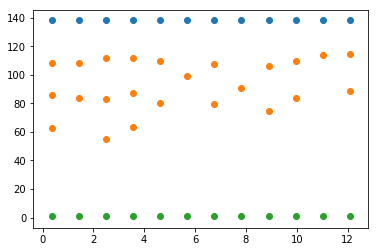

In [191]:
def sample_FT(f_t_model):
    sample_ft=np.zeros(len(f_t_model))
    for i, model in enumerate(f_t_model):
        if model==0:
            sample_ft[i]=np.random.normal(fast_mean,fast_sigma)
        if model==1:
            sample_ft[i]=np.random.normal(medium_mean,medium_sigma)
        if model==2:
            sample_ft[i]=np.random.normal(slow_mean,slow_sigma)
    return sample_ft
# sample scenario
def working_fur(p_pos):
    fur_idx=np.ones(len(p_pos))
    for i, pos in enumerate(p_pos):
        fur_idx[i]=math.floor((pos[0]-furrow_width/2)/(furrow_width+berry_width))+1
    return fur_idx
def sample_SCENE(sample_ft, p_pos, current_ft, pred_horizon, fur_idx):
    scene={} # target position and finish interval
    x_offset = furrow_width+berry_width
    y_offset = y_head+furrow_length
#     print x_offset, y_offset
    # frist one finish current furrow and pick the neareast one 
    for i,ft_interval, ft_cur in zip(range(len(sample_ft)),sample_ft, current_ft):
        n = int(math.floor((pred_horizon-ft_cur)/ft_interval) + 1) # obtain sample points on a furrow
#         print n, ft_cur
        pos_list, ft_list = [], []
        cur_pos = p_pos[i].reshape(-1,1)
        nxt_pos = np.copy(cur_pos)
        for j in range(n):
            if j==0:
                nxt_pos[1] = cur_pos[1]-v_pickers[i]*ft_cur # y
            else:
                nxt_pos[1] = cur_pos[1]-v_pickers[i]*ft_interval # y
            ft_tray=ft_interval # finish time of next tray
            if nxt_pos[1] < y_head:
                nxt_pos[0]=nxt_pos[0]+picker_num*x_offset
                nxt_pos[1]=y_offset-(y_head-nxt_pos[1])
                ft_tray=ft_interval + (cityblock(nxt_pos,cur_pos))/w_pickers[i]
#             print "next position", nxt_pos
            pos_list.append(nxt_pos)
#             print pos_list
            ft_list.append(ft_tray)
            cur_pos=np.copy(nxt_pos)
            nxt_pos=np.copy(cur_pos)
        print pos_list
        if len(pos_list)>1:
            scene['pos'+str(i)]=np.concatenate(pos_list,axis=1)
#             print scene['pos'+str(i)].shape
        else:
            scene['pos'+str(i)]=nxt_pos
        scene['ft'+str(i)]=np.asarray(ft_list)
    return scene
prediction_horizon=60*25 # 20 mins as prediction horizon
sample_ft = sample_FT(f_t_model) # sampled points based on current prediction
p_pos = p_initial_pos # current position of pickers
fur_idx = working_fur(p_pos) # working furrows of current pickers
f_t_state = np.copy(f_t_sample) # finishing time of current tray
scene_sample=sample_SCENE(sample_ft, p_pos, f_t_state, prediction_horizon, fur_idx)
print scene_sample
sample_points=[]
render=True
if render:
    for i in scene_sample.keys():
        char_sp = split('(\d+)',i)
        if char_sp[0] == 'pos':
            if len(scene_sample[i]) > 1:
                sample_points.append(scene_sample[i])
            print scene_sample[i].shape
    sample_points=np.concatenate(sample_points,axis=1)
    print sample_points.shape
    plt.scatter(p_pos[:,0],p_pos[:,1])
    plt.scatter(sample_points[0],sample_points[1])
    plt.scatter(p_pos[:,0],np.ones(p_pos[:,1].shape)*y_head)
    plt.show()

In [187]:
robot_assign=list(np.ones(robot_num)*(-1))
robot_assign[0]=1
robot_assign.index(0)

ValueError: 0 is not in list

In [195]:
# event driven problem, the system make decision when at least one robot is available
def produce_perm(scene_sample):
    perm=[]
    for i in scene_sample.keys():
        char_sp = split('(\d+)', i)
        if char_sp[0]=='pos':
            n=scene_sample[i].shape[1]
            num_list=[]
            for j in range(n):
                num_list.append(int(char_sp[1])+j*picker_num)
            perm.append(num_list)
    perm=np.concatenate(perm)
    perm=np.sort(perm)
    return perm  
perm=produce_perm(scene_sample)
print perm
robot_assign=list(np.ones(robot_num)*-1)
robot_pos = r_initial_pos
r_back_time = np.zeros(robot_num)
time_w = np.zeros(picker_num)
# f_t_state is actual state of pickers
def wait_time(scene_sample,f_t,r_back_time,robot_assign, perm_a, time_w):
    w_t = np.zeros(f_t.shape)
    # Next idle robot
    for i in perm_a:
        # no available robot, update states to available time
        if robot_assign.count(-1) < 1: 
            delta_t = np.amin(r_back_time)
            print delta_t
            robot_idx = np.argmin(r_back_time)
            # label idle robot
            robot_assign[robot_idx] = -1
            # update f_t
            r_back_time -= delta_t
            for m,ft in enumerate(f_t):
                if ft < delta_t:
                    f_t[m]=0
                    w_t[m] += delta_t-ft
                else:
                    f_t[m] = ft-delta_t
            print f_t,w_t
        k=robot_assign.index(-1) #return first idle robot number
        robot_assign[k]=i
        print robot_assign
        fur_num = i%picker_num
        col_num = int(i)/picker_num
        target_pos=scene_sample['pos'+str(fur_num)][:,col_num]
        target_ft=scene_sample['ft'+str(fur_num)][col_num]
        print target_pos
        if target_pos[0]>picker_num*(furrow_width+berry_width):
            r_to_target=cityblock(target_pos,center[1])/robot_v
            r_back_time[k]=np.maximum(r_to_target,target_ft)+r_to_target
        else:
            r_to_target=cityblock(target_pos,center[0])/robot_v
            r_back_time[k]=np.maximum(r_to_target,target_ft)+r_to_target
        print r_back_time
    return w_t    
# for i,ft in enumerate(f_t_state):
#     print i, ft
print center[1], center[0]
f_t=np.copy(f_t_sample)
print f_t
w_t = wait_time(scene_sample, f_t, r_back_time, robot_assign, perm, time_w)
print w_t.mean(), w_t.std()

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 20 21 23 24 26 27]
[ 19.2024   0.    ] [ 6.4008  0.    ]
[  523.27631216   701.80980466   462.04068487   469.2771459    667.39497423
  1164.56876516   537.96558499  1405.15001192   759.11812771   675.23981666
   721.6438269    707.28525035]
[0, -1.0, -1.0, -1.0]
[   0.3556      108.55856073]
[ 519.65869283    0.            0.            0.        ]
[0, 1, -1.0, -1.0]
[   1.4224      108.41926428]
[ 519.65869283  687.39392495    0.            0.        ]
[0, 1, 2, -1.0]
[   2.4892      112.02449724]
[ 519.65869283  687.39392495  622.58433616    0.        ]
[0, 1, 2, 3]
[   3.556       111.61491354]
[ 519.65869283  687.39392495  622.58433616  542.31059103]
519.658692829
[   3.61761933  182.15111183    0.            0.          147.7362814
  644.91007234   18.30689216  885.49131909  239.45943488  155.58112383
  201.98513407  187.62655752] [  0.           0.          57.61800796  50.38154693   0.           0.           0.
   0.        

In [12]:
import numpy as np
r_assign=np.ones(4)*-1

In [13]:
np.where(r_assign==-1)

(array([0, 1, 2, 3]),)

In [14]:
r_assign[0]=1
r_assign[1]=2
r_assign[2]=3

In [62]:
print r_assign
print np.where((r_assign<3) &(r_assign>3))[0].size
print np.where((r_assign<3) &(r_assign>3))

[ 0.  1.  1.  1.]
0
(array([], dtype=int64),)


In [46]:
r_assign[(r_assign>1)]-=1
print r_assign

[ 0.  1.  1.  1.]


In [47]:
for i in range(len(r_assign)):r_assign[i]=i

In [48]:
r_assign

array([ 0.,  1.,  2.,  3.])

In [51]:
r_assign[(r_assign>1)]-=1
print r_assign

[ 0.  1.  1.  1.]


In [1]:
import pygame

In [10]:
a=raw_input()
print a

10
10


In [15]:
np.where(r_assign==-1)

(array([3]),)

In [16]:
range(10)-[2,3,4,6,8]

TypeError: unsupported operand type(s) for -: 'list' and 'list'